In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
raw_df = pd.read_csv('./generalAccuracy_combined.csv.bz2', index_col=0)

#raw_df = pd.read_csv('./data/imdb-wiki_results/IMDB-WIKI_basicMethods_evaluated_iter500.csv')

#raw_df = pd.read_csv('./data/post_processing/EPIRA99_10trials.csv')

#raw_df['bias_applied'] = True
#raw_df = raw_df.rename(columns={'sampling strategy': 'sampling method', 'recovery method': 'Ranking Method'})

raw_df

,trial,iteration,value,bias_applied,sampling method,metric,group,Ranking Method
0,0,40,0.330061,False,RandomSampling,tau,Overall,GNNRank
1,0,40,0.340422,False,RandomSampling,tau,Privileged,GNNRank
2,0,40,0.322281,False,RandomSampling,tau,Unprivileged,GNNRank
3,0,40,0.357460,False,RandomSampling,tau,Privileged within-group,GNNRank
4,0,40,0.332949,False,RandomSampling,tau,Between groups,GNNRank
...,...,...,...,...,...,...,...,...
1495219,9,3000,0.123382,False,RankSampling,tau,Privileged within-group,SVD_RS
1495220,9,3000,0.122697,False,RankSampling,tau,Between groups,SVD_RS
1495221,9,3000,0.116647,False,RankSampling,tau,Unprivileged within-group,SVD_RS
1495222,9,3000,0.148397,False,RankSampling,exposure,Privileged,SVD_RS


In [3]:
sel_df = raw_df[raw_df.iteration == 500]
sel_df = sel_df.groupby(['iteration','bias_applied','sampling method','metric','group','Ranking Method']).mean().reset_index()
sel_df.loc[sel_df.metric == 'exposure', 'exposure'] = sel_df.value
sel_df.loc[sel_df.metric == 'tau', 'tau'] = sel_df.value
sel_df

,iteration,bias_applied,sampling method,metric,group,Ranking Method,trial,value,exposure,tau
0,500,False,OversampleMinority,exposure,Privileged,GNNRank,4.5,0.148988,0.148988,NaN
1,500,False,OversampleMinority,exposure,Privileged,PageRank,4.5,0.124022,0.124022,NaN
2,500,False,OversampleMinority,exposure,Privileged,SVD_NRS,4.5,0.150105,0.150105,NaN
3,500,False,OversampleMinority,exposure,Privileged,SVD_RS,4.5,0.134620,0.134620,NaN
4,500,False,OversampleMinority,exposure,Privileged,btl,4.5,0.151071,0.151071,NaN
...,...,...,...,...,...,...,...,...,...,...
523,500,True,RankSampling,tau,Unprivileged within-group,eigenvectorCentrality,4.5,0.325593,NaN,0.325593
524,500,True,RankSampling,tau,Unprivileged within-group,fairPageRank,4.5,0.263578,NaN,0.263578
525,500,True,RankSampling,tau,Unprivileged within-group,randomRankRecovery,4.5,0.715712,NaN,0.715712
526,500,True,RankSampling,tau,Unprivileged within-group,rankCentrality,4.5,0.435602,NaN,0.435602


In [4]:
priv_df = sel_df[sel_df.group == 'Privileged'].drop(columns=['iteration', 'trial', 'value'])
unpriv_df = sel_df[sel_df.group == 'Unprivileged'].drop(columns=['iteration', 'trial', 'value'])
priv_df

,bias_applied,sampling method,metric,group,Ranking Method,exposure,tau
0,False,OversampleMinority,exposure,Privileged,GNNRank,0.148988,NaN
1,False,OversampleMinority,exposure,Privileged,PageRank,0.124022,NaN
2,False,OversampleMinority,exposure,Privileged,SVD_NRS,0.150105,NaN
3,False,OversampleMinority,exposure,Privileged,SVD_RS,0.134620,NaN
4,False,OversampleMinority,exposure,Privileged,btl,0.151071,NaN
...,...,...,...,...,...,...,...
490,True,RankSampling,tau,Privileged,eigenvectorCentrality,NaN,0.357977
491,True,RankSampling,tau,Privileged,fairPageRank,NaN,0.277194
492,True,RankSampling,tau,Privileged,randomRankRecovery,NaN,0.711506
493,True,RankSampling,tau,Privileged,rankCentrality,NaN,0.353011


In [5]:
ratio_df = pd.merge(left=priv_df, left_on=['bias_applied','sampling method','metric','Ranking Method'],
                    right=unpriv_df, right_on=['bias_applied','sampling method','metric','Ranking Method'],
                    suffixes=('_priv', '_unpriv'))
ratio_df = ratio_df.drop(columns=['group_priv', 'group_unpriv'])
ratio_df['exposure ratio'] = ratio_df.exposure_unpriv / ratio_df.exposure_priv  # higher is better
ratio_df['error ratio'] = ratio_df.tau_priv / ratio_df.tau_unpriv  # lower is better
ratio_df

,bias_applied,sampling method,metric,Ranking Method,exposure_priv,tau_priv,exposure_unpriv,tau_unpriv,exposure ratio,error ratio
0,False,OversampleMinority,exposure,GNNRank,0.148988,NaN,0.147072,NaN,0.987138,NaN
1,False,OversampleMinority,exposure,PageRank,0.124022,NaN,0.172039,NaN,1.387167,NaN
2,False,OversampleMinority,exposure,SVD_NRS,0.150105,NaN,0.145955,NaN,0.972358,NaN
3,False,OversampleMinority,exposure,SVD_RS,0.134620,NaN,0.161441,NaN,1.199237,NaN
4,False,OversampleMinority,exposure,btl,0.151071,NaN,0.144989,NaN,0.959739,NaN
...,...,...,...,...,...,...,...,...,...,...
127,True,RankSampling,tau,eigenvectorCentrality,NaN,0.357977,NaN,0.387609,NaN,0.923552
128,True,RankSampling,tau,fairPageRank,NaN,0.277194,NaN,0.276003,NaN,1.004315
129,True,RankSampling,tau,randomRankRecovery,NaN,0.711506,NaN,0.714084,NaN,0.996390
130,True,RankSampling,tau,rankCentrality,NaN,0.353011,NaN,0.423440,NaN,0.833675


In [6]:
exp_df = ratio_df[ratio_df.metric == 'exposure']
tau_df = ratio_df[ratio_df.metric == 'tau']

overall_df = pd.merge(left=exp_df[['bias_applied','sampling method','Ranking Method', 'exposure ratio']],
                      left_on=['bias_applied','sampling method','Ranking Method'],
                      right=tau_df[['bias_applied','sampling method','Ranking Method', 'error ratio']],
                      right_on=['bias_applied','sampling method','Ranking Method'])

tau_overall_df = sel_df[sel_df.group == 'Overall'].drop(columns=['iteration', 'metric', 'group', 'trial', 'exposure', 'value']).rename(columns={'tau': 'error'})
overall_df = pd.merge(left=overall_df, left_on=['bias_applied','sampling method','Ranking Method'],
                      right=tau_overall_df, right_on=['bias_applied','sampling method','Ranking Method'])

overall_df

,bias_applied,sampling method,Ranking Method,exposure ratio,error ratio,error
0,False,OversampleMinority,GNNRank,0.987138,1.249710,0.076449
1,False,OversampleMinority,PageRank,1.387167,1.037410,0.348164
2,False,OversampleMinority,SVD_NRS,0.972358,1.240438,0.084751
3,False,OversampleMinority,SVD_RS,1.199237,1.100620,0.142501
4,False,OversampleMinority,btl,0.959739,1.083755,0.160528
...,...,...,...,...,...,...
61,True,RankSampling,eigenvectorCentrality,0.771602,0.923552,0.350314
62,True,RankSampling,fairPageRank,1.079066,1.004315,0.273654
63,True,RankSampling,randomRankRecovery,1.010792,0.996390,0.712804
64,True,RankSampling,rankCentrality,0.766455,0.833675,0.376669


In [7]:
overall_df = overall_df.replace({'OversampleMinority': 'Oversampling',
                                 'oversampling': 'Oversampling',
                                 'RankSampling': 'Rank-Based Sampling',
                                 'rankSampling': 'Rank-Based Sampling',
                                 'RandomSampling': 'Random Sampling',
                                 'randomSampling': 'Random Sampling',
                                 'fairPageRank': 'Fairness-Aware PageRank',
                                 'davidScore': "David's Score",
                                 'randomRankRecovery': 'Random Rank Recovery',
                                 'rankCentrality': 'Rank Centrality'})

overall_df = overall_df.rename(columns={'sampling method': 'Sampling Method'})

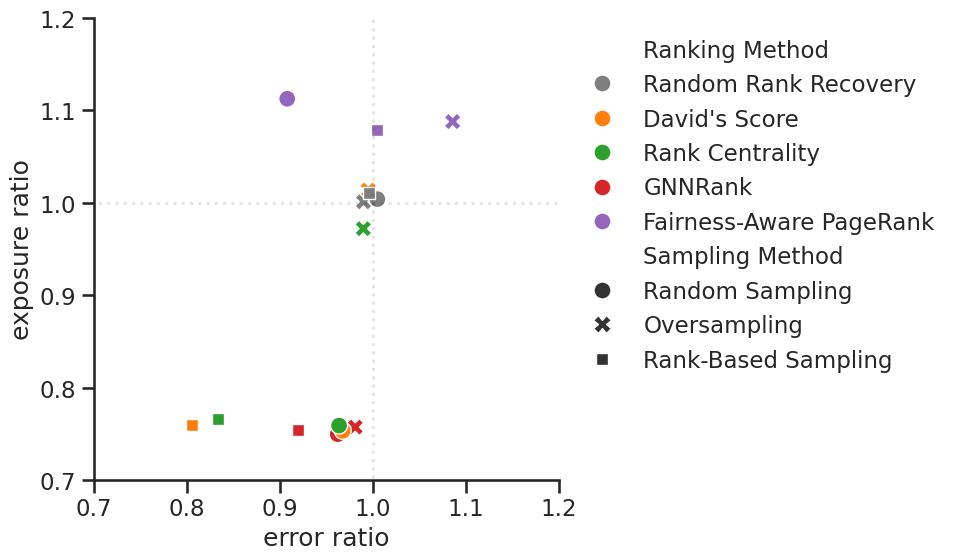

In [8]:
palette = sns.color_palette('tab10')
palette[0] = palette[7]
sns.set(rc={'figure.figsize':(6,6)})
sns.set_context("talk") # larger font size
sns.set_style('ticks')

df = overall_df[(overall_df.bias_applied)].copy()# & (overall_df['Sampling Method'] == 'Random Sampling')]
ranking_methods = ['Random Rank Recovery', "David's Score", 'Rank Centrality', 'GNNRank', 'Fairness-Aware PageRank']
sampling_methods = ['Random Sampling', 'Oversampling', 'Rank-Based Sampling']
df = df[df['Ranking Method'].isin(ranking_methods)]
#df['exposure ratio'] = df['exposure ratio'] + np.random.normal(0,0.001,len(df))
#df['error ratio'] = df['error ratio'] + np.random.normal(0,0.001,len(df))
#df['error'] = df['error'] + np.random.normal(0,0.001,len(df))

with sns.color_palette(palette):
    ax = sns.scatterplot(df, x='error ratio', y='exposure ratio', hue='Ranking Method', s=150, style='Sampling Method',
                         hue_order=['Random Rank Recovery', "David's Score", 'Rank Centrality', 'GNNRank', 'Fairness-Aware PageRank'],
                         style_order=['Random Sampling', 'Oversampling', 'Rank-Based Sampling'])
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.set(xlim=(0.7,1.2), ylim=(0.7,1.2))
plt.plot([0,2], [1,1], color='black', linestyle='dotted', alpha=0.1)
plt.plot([1,1], [0,2], color='black', linestyle='dotted', alpha=0.1)
sns.despine()

## Seperate 1D Plots

In [9]:
sel_df2 = raw_df[(raw_df.iteration == 500) & raw_df.bias_applied].drop(columns=['iteration', 'bias_applied'])
sel_df2 = sel_df2.pivot(index=['trial', 'sampling method', 'Ranking Method'], columns=['metric', 'group'], values='value').reset_index()
sel_df2

metric trial     sampling method         Ranking Method       tau             \
group                                                     Overall Privileged   
0          0  OversampleMinority                GNNRank  0.278917   0.306336   
1          0  OversampleMinority               PageRank  0.265023   0.284784   
2          0  OversampleMinority                SVD_NRS  0.324941   0.357344   
3          0  OversampleMinority                 SVD_RS  0.294831   0.324543   
4          0  OversampleMinority                    btl  0.272671   0.297707   
..       ...                 ...                    ...       ...        ...   
325        9        RankSampling  eigenvectorCentrality  0.393736   0.400490   
326        9        RankSampling           fairPageRank  0.312508   0.313939   
327        9        RankSampling     randomRankRecovery  0.708931   0.715522   
328        9        RankSampling         rankCentrality  0.385103   0.348847   
329        9        RankSampling             serialRank  0.644421   0.653120   

metric                                                      \
group  Unprivileged Privileged within-group Between groups   
0          0.317975                0.109930       0.369676   
1          0.257197                0.286298       0.283999   
2          0.368608                0.150953       0.428789   
3          0.324189                0.176238       0.376546   
4          0.312105                0.108536       0.360156   
..              ...                     ...            ...   
325        0.433342                0.219949       0.461520   
326        0.309595                0.320455       0.310465   
327        0.702725                0.726998       0.709665   
328        0.437564                0.149128       0.414768   
329        0.635864                0.667910       0.645241   

metric                             exposure               
group  Unprivileged within-group Privileged Unprivileged  
0                       0.162629   0.167684     0.128376  
1                       0.189997   0.133321     0.162739  
2                       0.179972   0.169240     0.126820  
3                       0.181733   0.145820     0.150241  
4                       0.160322   0.170231     0.125830  
..                           ...        ...          ...  
325                     0.374340   0.167853     0.128207  
326                     0.307682   0.142504     0.153556  
327                     0.688442   0.144943     0.151117  
328                     0.481741   0.167653     0.128407  
329                     0.615582   0.152601     0.143460  

[330 rows x 11 columns]

In [10]:
sel_df3 = sel_df2.copy()
sel_df3['exposure ratio'] = sel_df3['exposure']['Unprivileged'] / sel_df3['exposure']['Privileged']
sel_df3['error ratio'] = sel_df3['tau']['Unprivileged'] / sel_df3['tau']['Privileged']
sel_df3['error'] = sel_df3['tau']['Overall']
sel_df3 = sel_df3[['trial', 'sampling method', 'Ranking Method', 'exposure ratio', 'error ratio', 'error']].droplevel('group', axis=1)
sel_df3 = sel_df3.replace({'OversampleMinority': 'Oversampling',
                            'oversampling': 'Oversampling',
                            'RankSampling': 'Rank-Based Sampling',
                            'rankSampling': 'Rank-Based Sampling',
                            'RandomSampling': 'Random Sampling',
                            'randomSampling': 'Random Sampling',
                            'fairPageRank': 'Fairness-Aware PageRank',
                            'davidScore': "David's Score",
                            'randomRankRecovery': 'Random Rank Recovery',
                            'rankCentrality': 'Rank Centrality'})

sel_df3 = sel_df3.rename(columns={'sampling method': 'Sampling Method'})
sel_df3

metric,trial,Sampling Method,Ranking Method,exposure ratio,error ratio,error
0,0,Oversampling,GNNRank,0.765586,1.037996,0.278917
1,0,Oversampling,PageRank,1.220654,0.903128,0.265023
2,0,Oversampling,SVD_NRS,0.749351,1.031522,0.324941
3,0,Oversampling,SVD_RS,1.030320,0.998911,0.294831
4,0,Oversampling,btl,0.739172,1.048362,0.272671
...,...,...,...,...,...,...
325,9,Rank-Based Sampling,eigenvectorCentrality,0.763803,1.082030,0.393736
326,9,Rank-Based Sampling,Fairness-Aware PageRank,1.077553,0.986163,0.312508
327,9,Rank-Based Sampling,Random Rank Recovery,1.042597,0.982115,0.708931
328,9,Rank-Based Sampling,Rank Centrality,0.765912,1.254316,0.385103


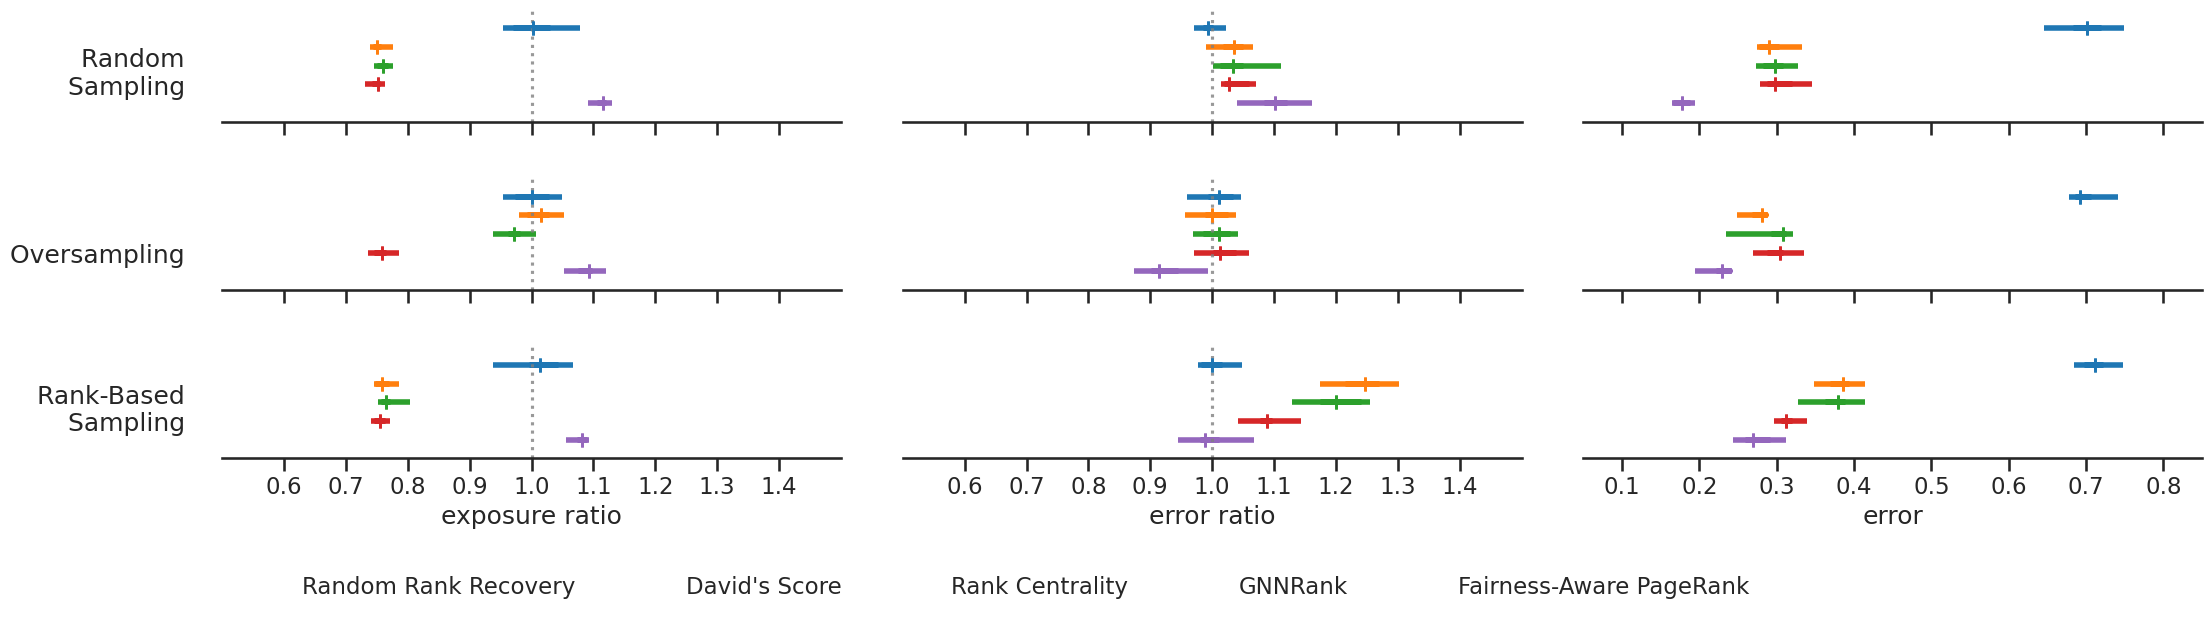

In [64]:
# Okabe-Ito color palette
lightblue = "#56B4E9"
yellow = "#F0E442"
orange = "#E69F00"
green = "#009E73"
purple = "#CC79A7"
red = "#D55E00"
blue = "#0072B2"
black = "#000000"
palette = [black, orange, lightblue, green, yellow, blue, red, purple]

palette = sns.color_palette('tab10')
#palette[0] = palette[7]

sns.set_context("talk") # larger font size
sns.set_style('ticks')

df = sel_df3
ranking_methods = ['Random Rank Recovery', "David's Score", 'Rank Centrality', 'GNNRank', 'Fairness-Aware PageRank']
sampling_methods = ['Random Sampling', 'Oversampling', 'Rank-Based Sampling']
metrics = ['exposure ratio', 'error ratio', 'error']

df = df[df['Ranking Method'].isin(ranking_methods)]
df = df.melt(id_vars=['Sampling Method', 'Ranking Method'], value_vars=['exposure ratio', 'error ratio', 'error'])

df['metric_order'] = df.metric.map(metrics.index)
df['sampling_order'] = df['Sampling Method'].map(sampling_methods.index)
df['ranking_order'] = df['Ranking Method'].map(list(reversed(ranking_methods)).index)
df = df.sort_values(by=['ranking_order', 'sampling_order', 'metric_order']).drop(columns=['ranking_order', 'sampling_order', 'metric_order'])

with sns.color_palette(palette):
    #g = sns.FacetGrid(df, row='Sampling Method', col='metric',
    #                  margin_titles=True)
    #g.map_dataframe(sns.pointplot, x='value', y='Ranking Method', hue='Ranking Method')
    g = sns.catplot(df, x='value', y='Ranking Method', kind='box', #style='Sampling Method',
                    row='Sampling Method', col='metric', hue='Ranking Method',
                    hue_order=ranking_methods, sharex=False, sharey=True,
                    aspect=4/1, height=2,
                    # sns.boxplot properties
                    fill=False, whis=100, linewidth=4,
                    # plt.boxplot properties & Line2D properties
                    medianprops={'marker': '|', 'markeredgewidth': 2, 'markersize': 10}, showcaps=False,
                    #showmeans=True, meanprops={'marker': '|', 'markeredgecolor': 'black', 'markeredgewidth': 2, 'markersize': 10},
                    widths=0)
    # s=40, alpha=0.8, facet_kws={'sharey': True, 'sharex': False}, height=1.8

sns.move_legend(g, 'upper left', ncol=5, title=None, bbox_to_anchor=(0.13, 0))#
g.refline(x=1, linestyle='dotted', alpha=0.8)
g.figure.subplots_adjust(wspace=0.1, hspace=0.5)

for (row_val, col_val), ax in g.axes_dict.items():
    ax.set_title(None)
    ax.set_yticks([-100])
    ax.set_ylim((-1,5))
    
    if row_val == 'Rank-Based Sampling':
        ax.set_xlabel(col_val)
    else:
        ax.set_xticklabels([])

    if col_val == 'error':
        ax.set(xlim=(0.05,0.85))
        ax.set_xticks([.1,.2,.3,.4,.5,.6,.7,.8])
    else:
        ax.set(xlim=(0.5,1.5))
        ax.set_xticks([.6,.7,.8,.9,1,1.1,1.2,1.3,1.4])
    
    if col_val == 'exposure ratio':
        ax.set_ylabel('    \n'.join(row_val.split()) + '    ', rotation=0, horizontalalignment='right', y=0.2)

sns.despine(left=True)
plt.savefig('./data/others_results/combined_results_1D_V2.png', dpi=300, bbox_inches="tight")

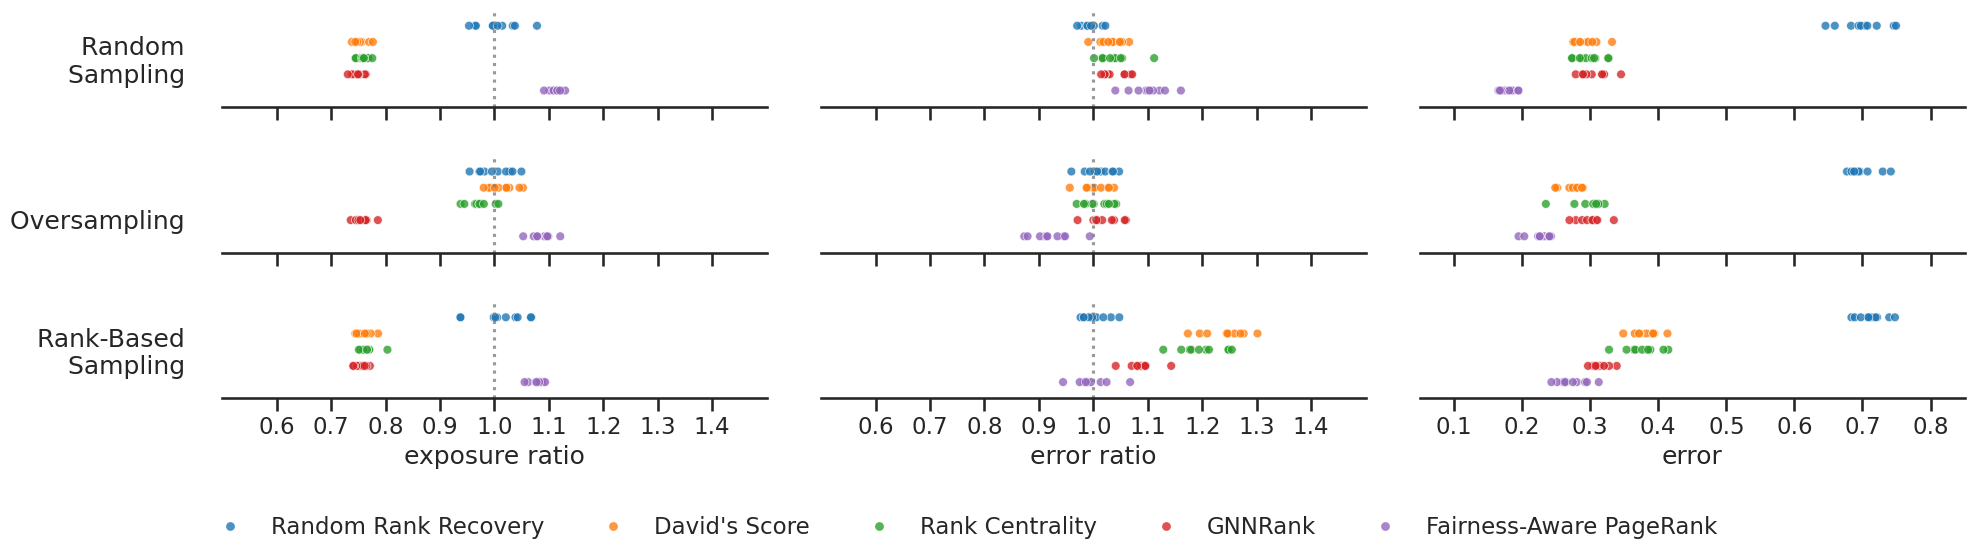

In [65]:
with sns.color_palette(palette):
    #g = sns.FacetGrid(df, row='Sampling Method', col='metric',
    #                  margin_titles=True)
    #g.map_dataframe(sns.pointplot, x='value', y='Ranking Method', hue='Ranking Method')
    g = sns.relplot(df, x='value', y='Ranking Method', hue='Ranking Method', kind='scatter', #style='Sampling Method',
                    row='Sampling Method', col='metric',
                    hue_order=ranking_methods, style_order=sampling_methods,
                    s=40, alpha=0.8, aspect=4/1, height=1.8, facet_kws={'sharey': True, 'sharex': False})

sns.move_legend(g, 'upper left', ncol=5, title=None, bbox_to_anchor=(0.13, 0))#
g.refline(x=1, linestyle='dotted', alpha=0.8)
g.figure.subplots_adjust(wspace=0.1, hspace=0.5)

for (row_val, col_val), ax in g.axes_dict.items():
    ax.set_title(None)
    ax.set_yticks([-100])
    ax.set_ylim((-1,5))
    
    if row_val == 'Rank-Based Sampling':
        ax.set_xlabel(col_val)
    else:
        ax.set_xticklabels([])

    if col_val == 'error':
        ax.set(xlim=(0.05,0.85))
        ax.set_xticks([.1,.2,.3,.4,.5,.6,.7,.8])
    else:
        ax.set(xlim=(0.5,1.5))
        ax.set_xticks([.6,.7,.8,.9,1,1.1,1.2,1.3,1.4])
    
    if col_val == 'exposure ratio':
        ax.set_ylabel('    \n'.join(row_val.split()) + '    ', rotation=0, horizontalalignment='right', y=0.2)

sns.despine(left=True)
plt.savefig('./data/others_results/combined_results_1D.png', dpi=300, bbox_inches="tight")